# Advanced Python for Finance Final Project

# Group No - 7

# Title - Analyzing the behaviour of the US stock markets on the basis of Macroeconomic factors

## Group Members - 

#### Javeria Malik
#### Kesava Ram
#### Manas Tokale
#### Tarun Raj
#### Varad Gandhi

#### Importing the necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#### Loading the data from the individual datasets

In [6]:
#Parsing the dates in order to set them up in the format
cpi = pd.read_csv('CPI.csv', parse_dates=['DATE'])
gdp = pd.read_csv('GDP.csv', parse_dates=['DATE'])
inflation = pd.read_csv('Inflation.csv', parse_dates=['DATE'])
pce = pd.read_csv('PCE.csv', parse_dates=['DATE'])
unemployment = pd.read_csv('Unemployment RATE.csv', parse_dates=['DATE'])
wm2ns = pd.read_csv('WM2NS.csv', parse_dates=['DATE'])

#### Downloading the S&P 500 data from yahoo finance

In [8]:
# Downloading S&P 500 data from Yahoo Finance 
stock_data = yf.download('^GSPC', start=cpi['DATE'].min(), end=cpi['DATE'].max())
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1947-01-02,15.200000,15.200000,15.200000,15.200000,15.200000,0
1947-01-03,15.260000,15.260000,15.260000,15.260000,15.260000,0
1947-01-06,15.440000,15.440000,15.440000,15.440000,15.440000,0
1947-01-07,15.320000,15.320000,15.320000,15.320000,15.320000,0
1947-01-08,15.410000,15.410000,15.410000,15.410000,15.410000,0
...,...,...,...,...,...,...
2024-09-24,5727.660156,5735.319824,5698.990234,5732.930176,5732.930176,3872710000
2024-09-25,5733.649902,5741.029785,5712.060059,5722.259766,5722.259766,3624910000
2024-09-26,5762.220215,5767.370117,5721.009766,5745.370117,5745.370117,4391180000


In [9]:
#Keeping only the Adj Close values, dropping the rest
stock_data.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)

In [10]:
stock_data

,Adj Close
Date,
1947-01-02,15.200000
1947-01-03,15.260000
1947-01-06,15.440000
1947-01-07,15.320000
1947-01-08,15.410000
...,...
2024-09-24,5732.930176
2024-09-25,5722.259766
2024-09-26,5745.370117


#### Calculating the returns from the data

In [12]:
# Using adjusted close prices to calculate returns
stock_data['Returns'] = stock_data['Adj Close'].pct_change() * 100

In [13]:
stock_data

,Adj Close,Returns
Date,,
1947-01-02,15.200000,NaN
1947-01-03,15.260000,0.394740
1947-01-06,15.440000,1.179550
1947-01-07,15.320000,-0.777201
1947-01-08,15.410000,0.587468
...,...,...
2024-09-24,5732.930176,0.251118
2024-09-25,5722.259766,-0.186125
2024-09-26,5745.370117,0.403868


#### Merging economic indicators together into a single dataframe

##### First interpolating the GDP values to monthly since they are provided in a quarterly fashion

In [16]:
#Using the interpolate method to develop quarterly data into monthly fashion
gdp.set_index('DATE', inplace=True)
gdp = gdp.resample('MS').interpolate(method='linear')
gdp= gdp.reset_index()

In [17]:
gdp

,DATE,GDP
0,1947-01-01,243.164000
1,1947-02-01,244.098667
2,1947-03-01,245.033333
3,1947-04-01,245.968000
4,1947-05-01,247.173667
...,...,...
926,2024-03-01,28885.832333
927,2024-04-01,29016.714000
928,2024-05-01,29129.249667
929,2024-06-01,29241.785333


##### Now merging the data together

In [19]:
data = cpi.merge(gdp, on='DATE', how='outer')
data = data.merge(inflation, on='DATE', how='outer')
data = data.merge(pce, on='DATE', how='outer')
data = data.merge(unemployment, on='DATE', how='outer')
data = data.merge(wm2ns, on='DATE', how='outer')

In [20]:
data

,DATE,CPIAUCSL,GDP,CORESTICKM159SFRBATL,PCE,UNRATE,WM2NS
0,1947-01-01,21.480,243.164000,NaN,NaN,NaN,NaN
1,1947-02-01,21.620,244.098667,NaN,NaN,NaN,NaN
2,1947-03-01,22.000,245.033333,NaN,NaN,NaN,NaN
3,1947-04-01,22.000,245.968000,NaN,NaN,NaN,NaN
4,1947-05-01,21.950,247.173667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
930,2024-07-01,313.534,29354.321000,4.164951,19859.3,4.3,20960.100000000000
931,2024-08-01,314.121,NaN,4.103706,19898.0,4.2,21066.650000000000
932,2024-09-01,314.686,NaN,4.010873,20027.2,4.1,21165.660000000000
933,2024-10-01,315.454,NaN,3.965451,20099.5,4.1,21228.075000000000


##### Merging with the stock data

In [22]:
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
data['DATE'] = pd.to_datetime(data['DATE']).dt.date

# Merging the datasets on the date
merged_data = pd.merge(stock_data, data, left_on='Date', right_on='DATE', how='inner')

In [23]:
# Dropping the redundant 'DATE' column
merged_data = merged_data.drop(columns=['DATE'])

df = merged_data.dropna()

#### Creating a correlation matrix

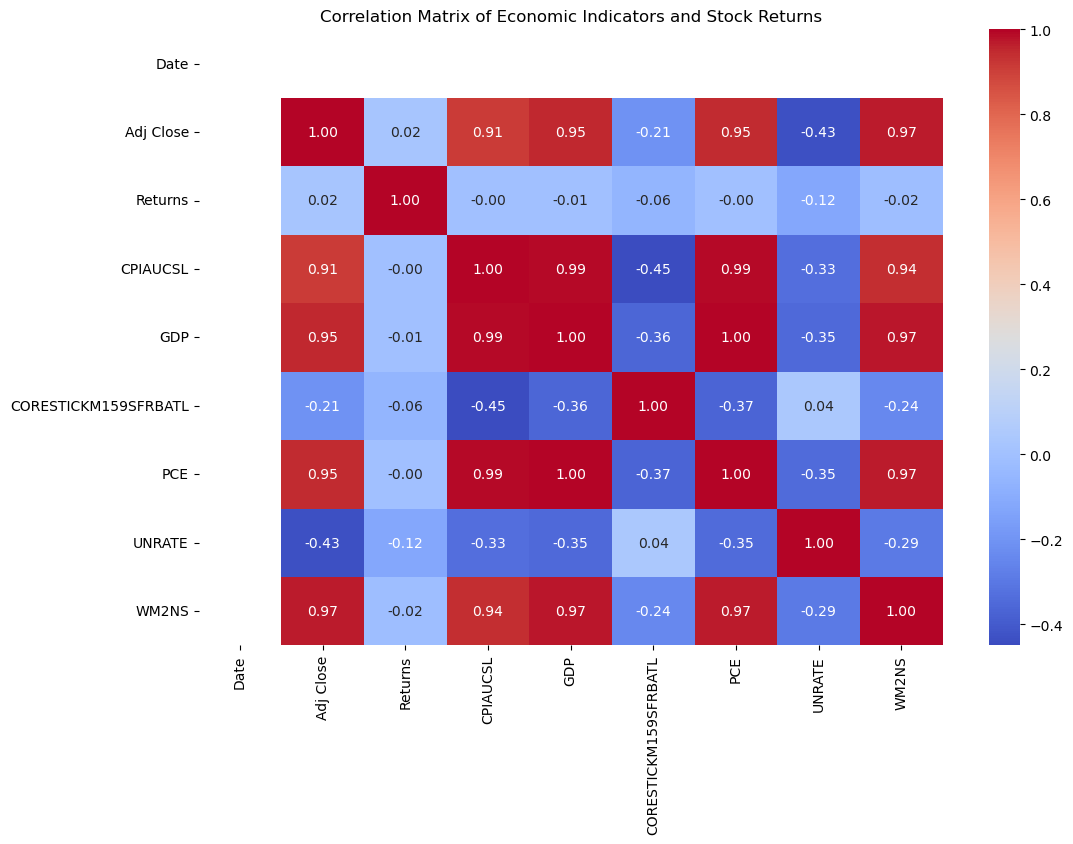

In [25]:
# Convert the dataframe to numeric, forcing errors to NaN
df2 = df.apply(pd.to_numeric, errors='coerce')

# Now calculate the correlation matrix
corr_matrix = df2.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Economic Indicators and Stock Returns')
plt.show()

#### Splitting the data into train and test sets for generating the linear regression model

In [27]:
#Creating the dependent and independent variables
X = df[['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']]  # Economic indicators
y = df['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Developing the Linear regression model 

In [29]:
# Create and training the model on the training data and calculating the MSE of the data
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 43909.76583857999


#### Identifying the coefficients for the regression model

In [31]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients

,Coefficient
CPIAUCSL,-13.638918
GDP,0.478937
CORESTICKM159SFRBATL,-17.977546
PCE,-0.468988
UNRATE,-89.402621
WM2NS,0.141159


In [32]:
print(f"R-squared: {model.score(X, y)}")

R-squared: 0.9678276456648912


In [33]:
df['WM2NS']=pd.to_numeric(df['WM2NS'])

C:\Users\Varad\AppData\Local\Temp\ipykernel_20616\1467451361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WM2NS']=pd.to_numeric(df['WM2NS'])


In [34]:
x=df[["CPIAUCSL","GDP","CORESTICKM159SFRBATL","PCE","UNRATE","WM2NS"]]
sm.OLS(df['Adj Close'], sm.add_constant(x)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1667.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          2.15e-243
Time:                        21:21:21   Log-Likelihood:                -2295.3
No. Observations:                 337   AIC:                             4605.
Df Residuals:                     330   BIC:                             4631.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1409.1128    230.760      6.106      0.000     955.167    1863.059
CPIAUCSL               -15.4949      2.673     -5.796      0.000     -20.754     -10.236
GDP                      0.4962      0.089      5.584      0.000       0.321       0.671
CORESTICKM159SFRBATL   -12.9688     10.017     -1.295      0.196     -32.674       6.737
PCE                     -0.4537      0.115     -3.949      0.000      -0.680      -0.228
UNRATE                 -87.6493      7.703    -11.379      0.000    -102.802     -72.497
WM2NS                    0.1289      0.015      8.416      0.000       0.099       0.159
==============================================================================
Omnibus:                       58.713   Durbin-Watson:                   0.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.305
Skew:                           0.913   Prob(JB):                     7.52e-27
Kurtosis:                       5.288   Cond. No.                     3.76e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Plotting the actual vs Predicted stock returns

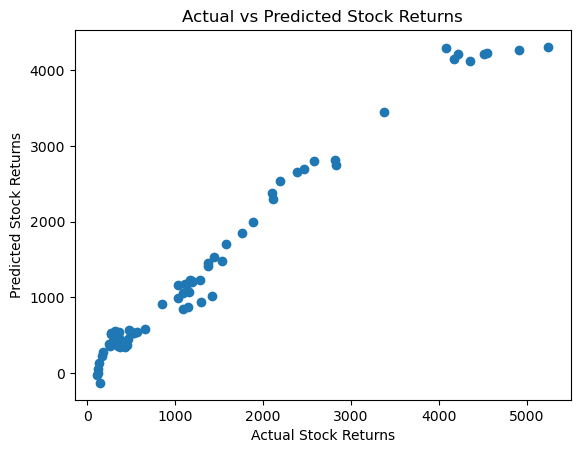

In [36]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Stock Returns')
plt.ylabel('Predicted Stock Returns')
plt.title('Actual vs Predicted Stock Returns')
plt.show()

#### Plotting the data

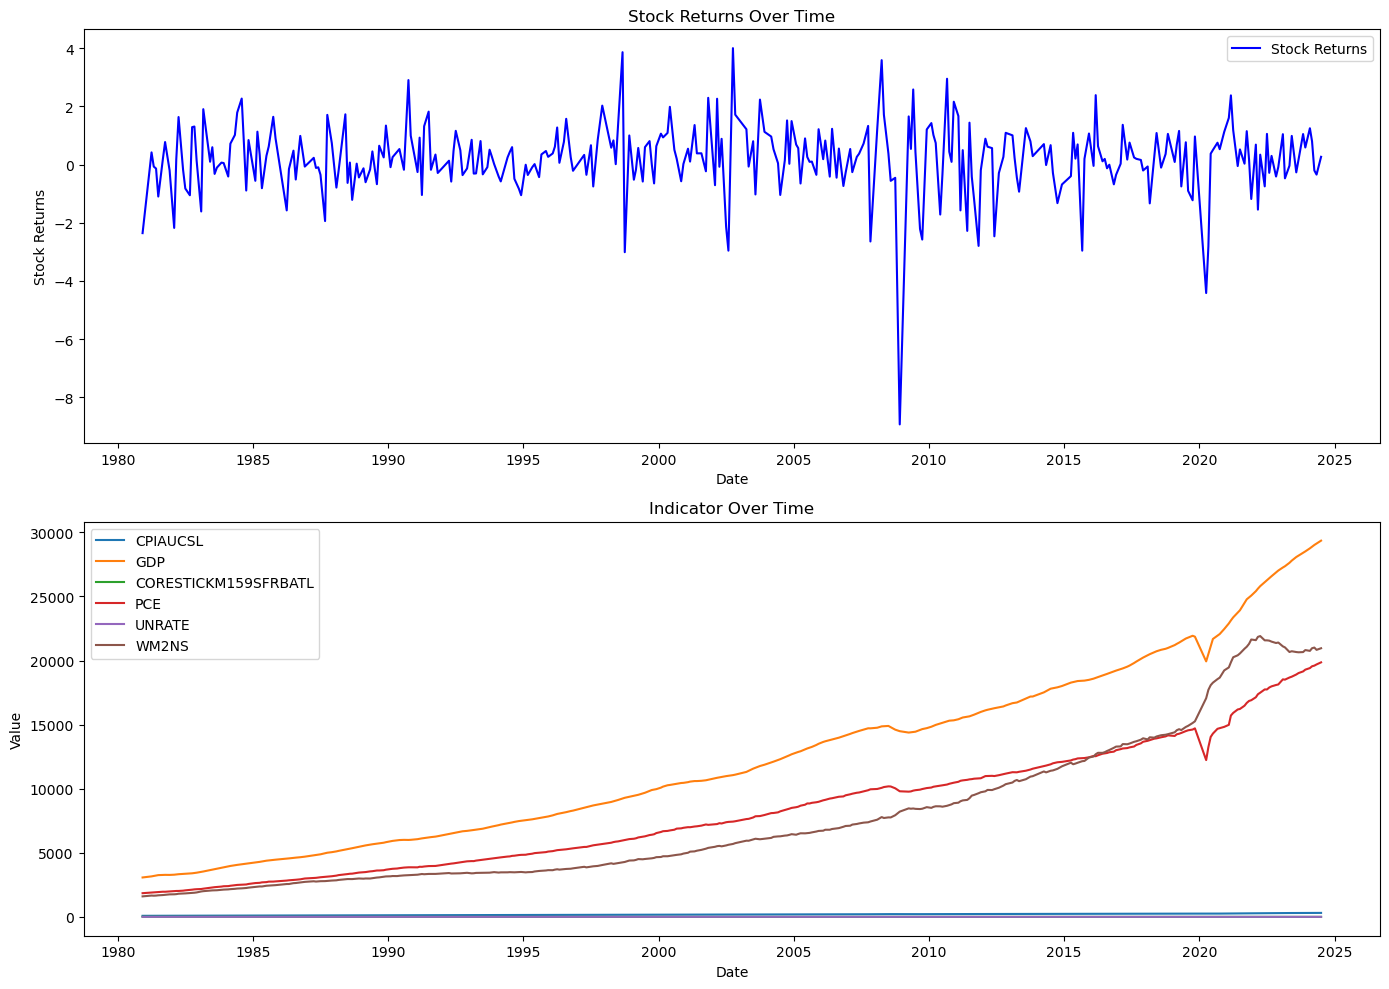

In [38]:
econ_indicators = ['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']
plt.figure(figsize=(14, 10))

# Plotting stock returns
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Returns'], label='Stock Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
plt.legend()

# Plotting each economic indicator
for indicator in econ_indicators:
    plt.subplot(2, 1, 2)
    plt.plot(df['Date'], df[indicator], label=indicator)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Indicator Over Time')
    plt.legend()

plt.tight_layout()
plt.show()

#### Plotting the actual vs predicted values

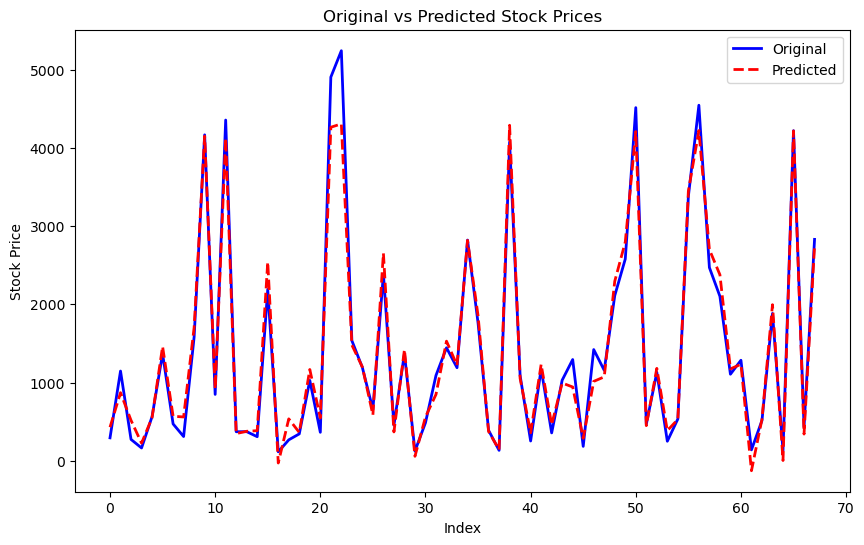

In [40]:
# Plot the original vs predicted values
plt.figure(figsize=(10, 6))

# Plotting the actual stock prices
plt.plot(y_test.values, label='Original', color='blue', linewidth=2)

# Plotting the predicted stock prices
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('Original vs Predicted Stock Prices')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()

# Displaying the plot
plt.show()

### Nasdaq Composite Index

#### Downloading the NASDAQ data from yahoo finance

In [43]:
# Downloading the Adj Close prices of NASDAQ data 
stock_data1 = yf.download('^IXIC', start=cpi['DATE'].min(), end=cpi['DATE'].max())
stock_data1

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...
2024-09-24,18046.439453,18091.960938,17863.380859,18074.519531,18074.519531,5347580000
2024-09-25,18050.359375,18155.039062,18040.619141,18082.210938,18082.210938,4858060000
2024-09-26,18327.339844,18327.339844,18071.740234,18190.289062,18190.289062,5669210000


In [44]:
stock_data1.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)

In [45]:
stock_data1

,Adj Close
Date,
1971-02-05,100.000000
1971-02-08,100.839996
1971-02-09,100.760002
1971-02-10,100.690002
1971-02-11,101.449997
...,...
2024-09-24,18074.519531
2024-09-25,18082.210938
2024-09-26,18190.289062


#### Calculating returns from the data

In [47]:
# Use adjusted close prices to calculate returns
stock_data1['Returns'] = stock_data1['Adj Close'].pct_change() * 100

In [48]:
stock_data1

,Adj Close,Returns
Date,,
1971-02-05,100.000000,NaN
1971-02-08,100.839996,0.839996
1971-02-09,100.760002,-0.079328
1971-02-10,100.690002,-0.069472
1971-02-11,101.449997,0.754786
...,...,...
2024-09-24,18074.519531,0.557742
2024-09-25,18082.210938,0.042554
2024-09-26,18190.289062,0.597704


#### Merging the stock market data with the Macroeconomic data

In [50]:
stock_data1 = stock_data1.reset_index()
stock_data1['Date'] = pd.to_datetime(stock_data1['Date']).dt.date
data['DATE'] = pd.to_datetime(data['DATE']).dt.date

# Merge the datasets on the date
merged_data1 = pd.merge(stock_data1, data, left_on='Date', right_on='DATE', how='inner')

In [51]:
merged_data1

,Date,Adj Close,Returns,DATE,CPIAUCSL,GDP,CORESTICKM159SFRBATL,PCE,UNRATE,WM2NS
0,1971-03-01,101.779999,0.434184,1971-03-01,40.000,1149.232667,5.501608,682.0,6.0,NaN
1,1971-04-01,106.339996,0.349151,1971-04-01,40.100,1156.271000,5.306251,688.8,5.9,NaN
2,1971-06-01,108.870003,0.572751,1971-06-01,40.500,1170.540333,5.239200,699.8,5.9,NaN
3,1971-07-01,108.470001,0.621520,1971-07-01,40.600,1177.675000,5.165044,698.9,6.0,NaN
4,1971-09-01,108.650002,0.212141,1971-09-01,40.800,1186.089667,4.672385,713.0,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...
408,2024-03-01,16274.940430,1.137344,2024-03-01,312.230,28885.832333,4.509212,19553.2,3.8,20961.200000000000
409,2024-04-01,16396.830078,0.106048,2024-04-01,313.207,29016.714000,4.412395,19603.3,3.9,21012.880000000000
410,2024-05-01,15605.480469,-0.334273,2024-05-01,313.225,29129.249667,4.302023,19697.3,4.0,20834.475000000000
411,2024-07-01,17879.300781,0.827296,2024-07-01,313.534,29354.321000,4.164951,19859.3,4.3,20960.100000000000


In [52]:
# Dropping the redundant 'DATE' column
merged_data1 = merged_data1.drop(columns=['DATE'])

df3 = merged_data1.dropna()

#### Creating a correlation matrix

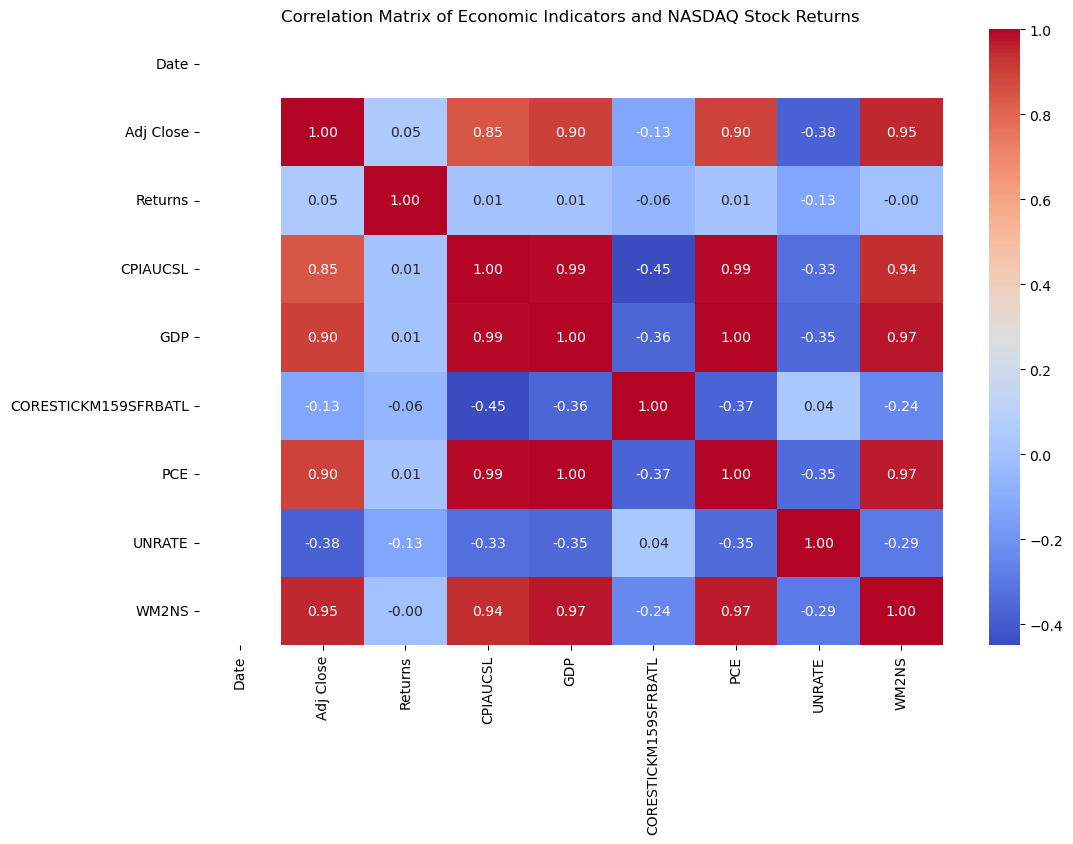

In [54]:
# Convert the dataframe to numeric, forcing errors to NaN
df4 = df3.apply(pd.to_numeric, errors='coerce')

# Now calculate the correlation matrix
corr_matrix = df4.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Economic Indicators and NASDAQ Stock Returns')
plt.show()

#### Splitting the data into train and test for model

In [56]:
X = df3[['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']]  # Economic indicators
y = df3['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Developing the linear regression model

In [58]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 870735.1325792568


#### Identifying the coefficients for the model

In [60]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients

,Coefficient
CPIAUCSL,-60.676824
GDP,1.779028
CORESTICKM159SFRBATL,-95.378130
PCE,-2.080028
UNRATE,-224.986979
WM2NS,0.797432


In [61]:
print(f"R-squared: {model.score(X, y)}")

R-squared: 0.9456821074137638


In [62]:
df3['WM2NS']=pd.to_numeric(df3['WM2NS'])

C:\Users\Varad\AppData\Local\Temp\ipykernel_20616\1708958858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['WM2NS']=pd.to_numeric(df3['WM2NS'])


In [63]:
x=df3[["CPIAUCSL","GDP","CORESTICKM159SFRBATL","PCE","UNRATE","WM2NS"]]
sm.OLS(df3['Adj Close'], sm.add_constant(x)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     974.9
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          1.39e-206
Time:                        21:21:23   Log-Likelihood:                -2780.3
No. Observations:                 337   AIC:                             5575.
Df Residuals:                     330   BIC:                             5601.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6108.9135    973.384      6.276      0.000    4194.093    8023.734
CPIAUCSL               -69.8982     11.276     -6.199      0.000     -92.080     -47.716
GDP                      1.3946      0.375      3.721      0.000       0.657       2.132
CORESTICKM159SFRBATL   -77.6665     42.254     -1.838      0.067    -160.788       5.455
PCE                     -1.3566      0.485     -2.799      0.005      -2.310      -0.403
UNRATE                -246.9426     32.491     -7.600      0.000    -310.859    -183.026
WM2NS                    0.7596      0.065     11.759      0.000       0.632       0.887
==============================================================================
Omnibus:                       90.794   Durbin-Watson:                   0.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              312.917
Skew:                           1.158   Prob(JB):                     1.12e-68
Kurtosis:                       7.113   Cond. No.                     3.76e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Plotting the actual vs predicted stock returns

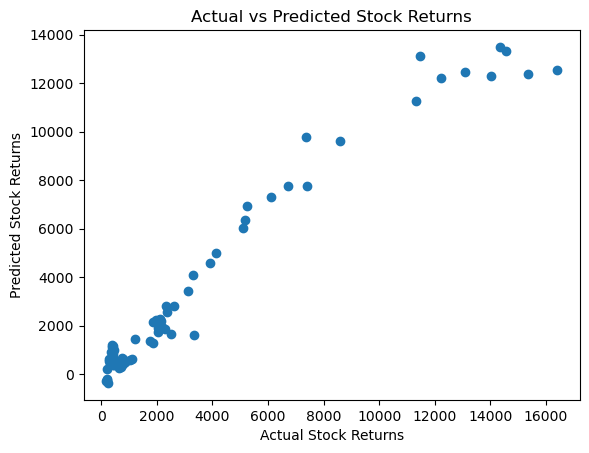

In [65]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Stock Returns')
plt.ylabel('Predicted Stock Returns')
plt.title('Actual vs Predicted Stock Returns')
plt.show()

#### Plotting the data

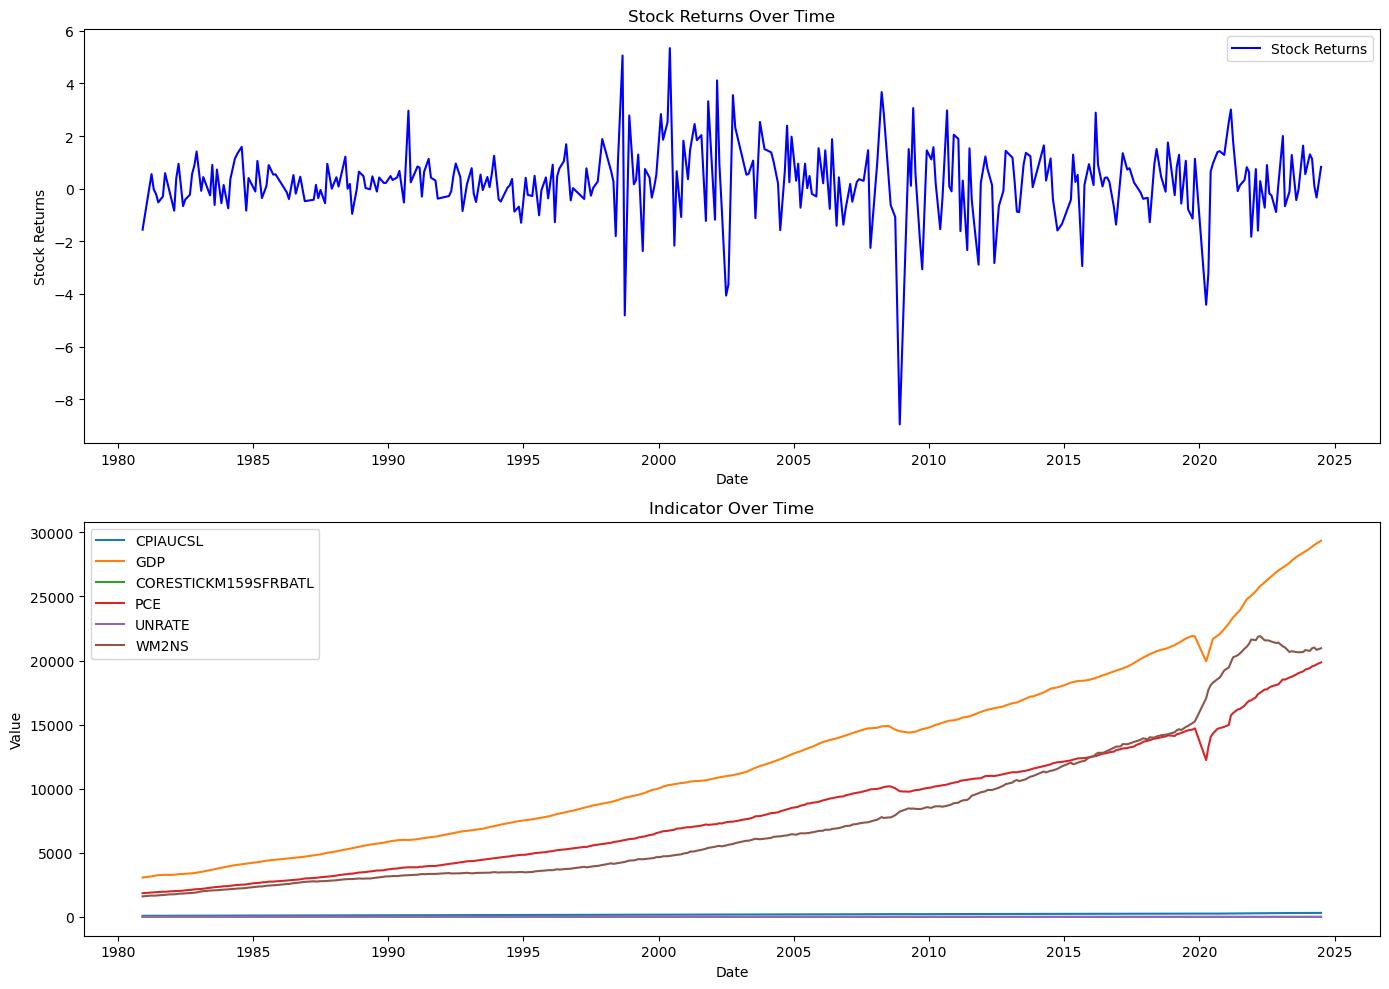

In [67]:
econ_indicators = ['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']
plt.figure(figsize=(14, 10))

# Plot stock returns
plt.subplot(2, 1, 1)
plt.plot(df3['Date'], df3['Returns'], label='Stock Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
plt.legend()

# Plot each economic indicator
for indicator in econ_indicators:
    plt.subplot(2, 1, 2)
    plt.plot(df3['Date'], df3[indicator], label=indicator)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Indicator Over Time')
    plt.legend()

plt.tight_layout()
plt.show()

#### Plotting the actual vs predicted values

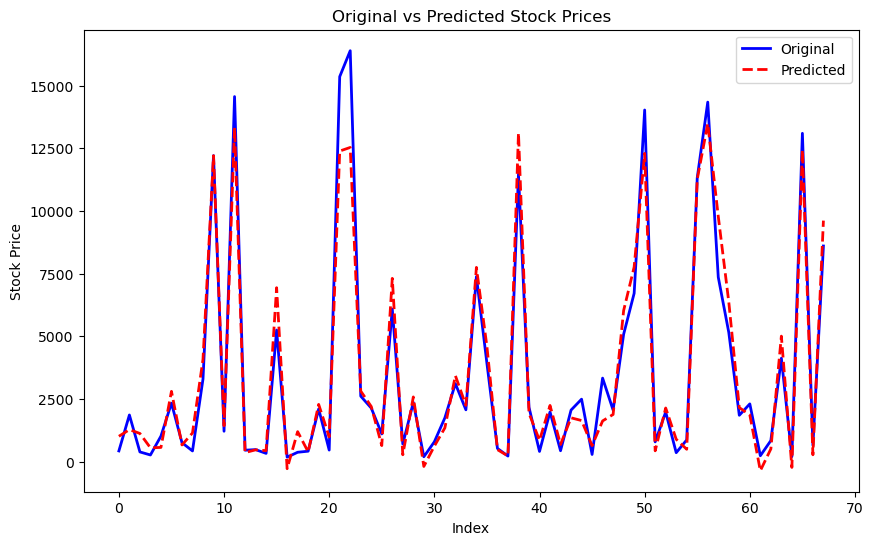

In [69]:
# Plot the original vs predicted values
plt.figure(figsize=(10, 6))

# Plotting the actual stock prices
plt.plot(y_test.values, label='Original', color='blue', linewidth=2)

# Plotting the predicted stock prices
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('Original vs Predicted Stock Prices')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()

# Display the plot
plt.show()

### Dow Jones Index

#### Downloading the Dow Jones data from Yahoo finance

In [72]:
# Downloading the Adj Close prices of S&P 500 data 
stock_data2 = yf.download('^DJI', start=cpi['DATE'].min(), end=cpi['DATE'].max())
stock_data2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-01-02,3152.100098,3172.629883,3139.310059,3172.399902,3172.399902,23550000
1992-01-03,3172.399902,3210.639893,3165.919922,3201.500000,3201.500000,23620000
1992-01-06,3201.500000,3213.330078,3191.860107,3200.100098,3200.100098,27280000
1992-01-07,3200.100098,3210.199951,3184.479980,3204.800049,3204.800049,25510000
1992-01-08,3204.800049,3229.199951,3185.820068,3203.899902,3203.899902,29040000
...,...,...,...,...,...,...
2024-09-24,42234.988281,42281.058594,42056.820312,42208.218750,42208.218750,401020000
2024-09-25,42236.089844,42299.640625,41859.730469,41914.750000,41914.750000,374960000
2024-09-26,42113.421875,42224.148438,42036.281250,42175.109375,42175.109375,353600000


In [73]:
stock_data2.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)

In [74]:
stock_data2

,Adj Close
Date,
1992-01-02,3172.399902
1992-01-03,3201.500000
1992-01-06,3200.100098
1992-01-07,3204.800049
1992-01-08,3203.899902
...,...
2024-09-24,42208.218750
2024-09-25,41914.750000
2024-09-26,42175.109375


#### Calculating returns from the data

In [76]:
stock_data2['Returns'] = stock_data2['Adj Close'].pct_change() * 100

In [77]:
stock_data2

,Adj Close,Returns
Date,,
1992-01-02,3172.399902,NaN
1992-01-03,3201.500000,0.917290
1992-01-06,3200.100098,-0.043726
1992-01-07,3204.800049,0.146869
1992-01-08,3203.899902,-0.028087
...,...,...
2024-09-24,42208.218750,0.198388
2024-09-25,41914.750000,-0.695288
2024-09-26,42175.109375,0.621164


#### Merging data with the macroeconomic data

In [79]:
stock_data2 = stock_data2.reset_index()
stock_data2['Date'] = pd.to_datetime(stock_data2['Date']).dt.date
data['DATE'] = pd.to_datetime(data['DATE']).dt.date

# Merge the datasets on the date
merged_data2 = pd.merge(stock_data2, data, left_on='Date', right_on='DATE', how='inner')

In [80]:
# Dropping the redundant 'DATE' column
merged_data2 = merged_data2.drop(columns=['DATE'])

df5 = merged_data2.dropna()

In [81]:
df5

,Date,Adj Close,Returns,CPIAUCSL,GDP,CORESTICKM159SFRBATL,PCE,UNRATE,WM2NS
0,1992-04-01,3249.300049,0.426520,139.400,6470.763000,4.066439,4131.5,7.4,3423.3750000000000000
1,1992-05-01,3336.100098,-0.684707,139.700,6502.722333,3.926411,4158.4,7.6,3388.2250000000000000
2,1992-06-01,3413.199951,0.479851,140.100,6534.681667,3.860189,4177.1,7.8,3387.4600000000000000
3,1992-07-01,3354.100098,1.072777,140.500,6566.641000,3.769368,4204.8,7.7,3394.8750000000000000
4,1992-09-01,3266.260010,0.271999,141.100,6642.749000,3.349238,4255.3,7.6,3402.0750000000000000
...,...,...,...,...,...,...,...,...,...
248,2024-02-01,38519.839844,0.968640,311.054,28754.950667,4.403102,19412.7,3.9,20754.950000000000
249,2024-03-01,39087.378906,0.233325,312.230,28885.832333,4.509212,19553.2,3.8,20961.200000000000
250,2024-04-01,39566.851562,-0.604209,313.207,29016.714000,4.412395,19603.3,3.9,21012.880000000000
251,2024-05-01,37903.289062,0.231033,313.225,29129.249667,4.302023,19697.3,4.0,20834.475000000000


#### Creating a correlation matrix

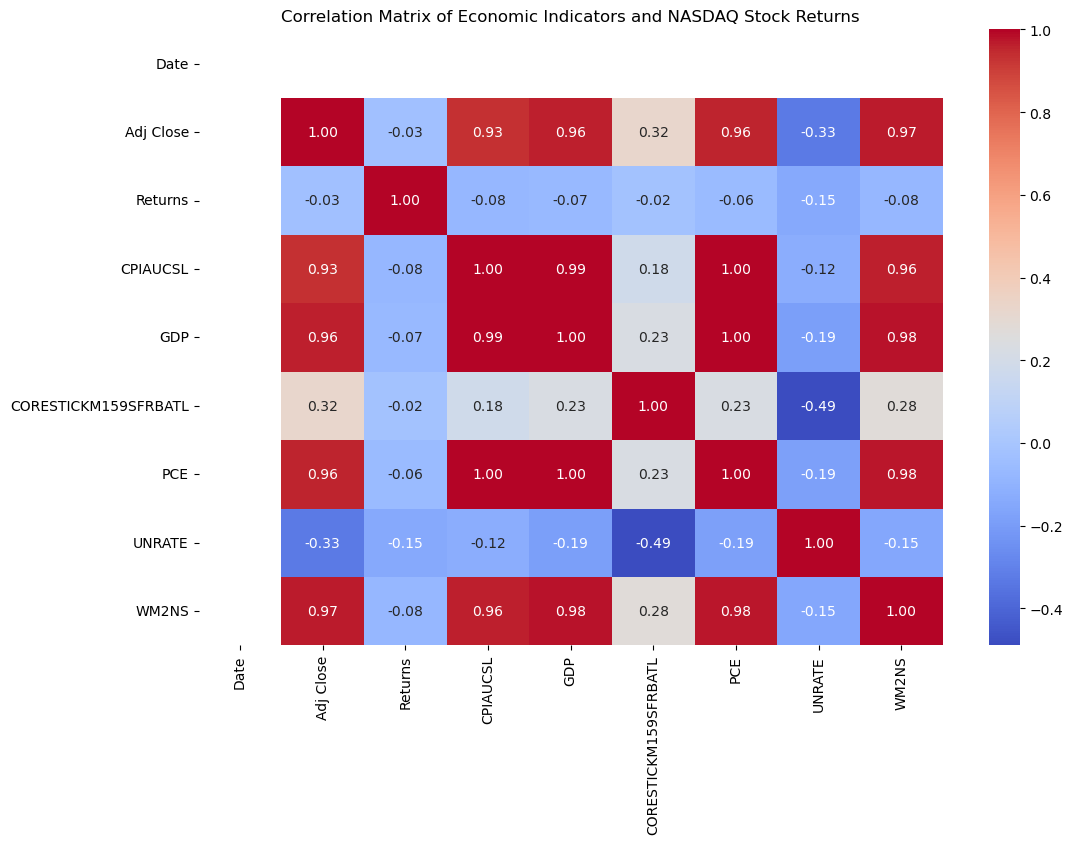

In [83]:
# Convert the dataframe to numeric, forcing errors to NaN
df6 = df5.apply(pd.to_numeric, errors='coerce')

# Now calculate the correlation matrix
corr_matrix = df6.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Economic Indicators and NASDAQ Stock Returns')
plt.show()

#### Splitting the data into train and test model

In [85]:
X = df5[['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']]  # Economic indicators
y = df5['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Developing the linear regression model

In [87]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2236757.334035695


#### Identifying the coefficients on the model

In [89]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients

,Coefficient
CPIAUCSL,-211.042391
GDP,3.724553
CORESTICKM159SFRBATL,-412.194553
PCE,-2.274529
UNRATE,-628.887323
WM2NS,0.993935


In [90]:
print(f"R-squared: {model.score(X, y)}")

R-squared: 0.980281855116079


In [91]:
df5['WM2NS']=pd.to_numeric(df5['WM2NS'])

C:\Users\Varad\AppData\Local\Temp\ipykernel_20616\3954384523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['WM2NS']=pd.to_numeric(df5['WM2NS'])


In [92]:
x=df5[["CPIAUCSL","GDP","CORESTICKM159SFRBATL","PCE","UNRATE","WM2NS"]]
sm.OLS(df5['Adj Close'], sm.add_constant(x)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2056.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          4.90e-207
Time:                        21:21:26   Log-Likelihood:                -2177.7
No. Observations:                 253   AIC:                             4369.
Df Residuals:                     246   BIC:                             4394.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.267e+04   2983.845      7.598      0.000    1.68e+04    2.85e+04
CPIAUCSL              -234.0347     36.129     -6.478      0.000    -305.197    -162.872
GDP                      3.7764      0.554      6.821      0.000       2.686       4.867
CORESTICKM159SFRBATL  -370.1245    103.067     -3.591      0.000    -573.132    -167.117
PCE                     -1.9175      0.755     -2.541      0.012      -3.404      -0.431
UNRATE                -573.5617     81.876     -7.005      0.000    -734.829    -412.295
WM2NS                    0.8704      0.110      7.903      0.000       0.653       1.087
==============================================================================
Omnibus:                        2.609   Durbin-Watson:                   0.395
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.560
Skew:                          -0.091   Prob(JB):                        0.278
Kurtosis:                       3.458   Cond. No.                     7.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Plotting actual vs predicted values

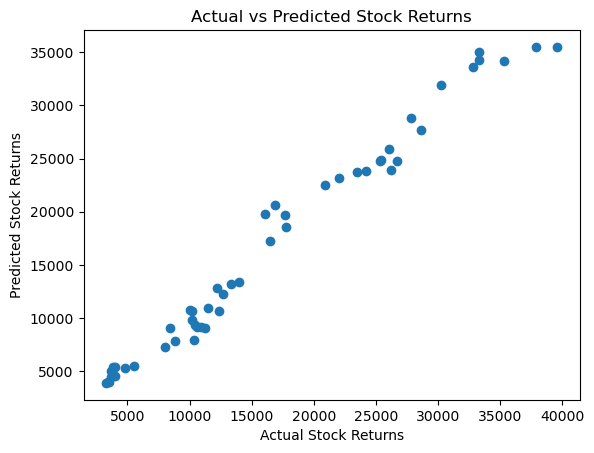

In [94]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Stock Returns')
plt.ylabel('Predicted Stock Returns')
plt.title('Actual vs Predicted Stock Returns')
plt.show()

#### Plotting the data

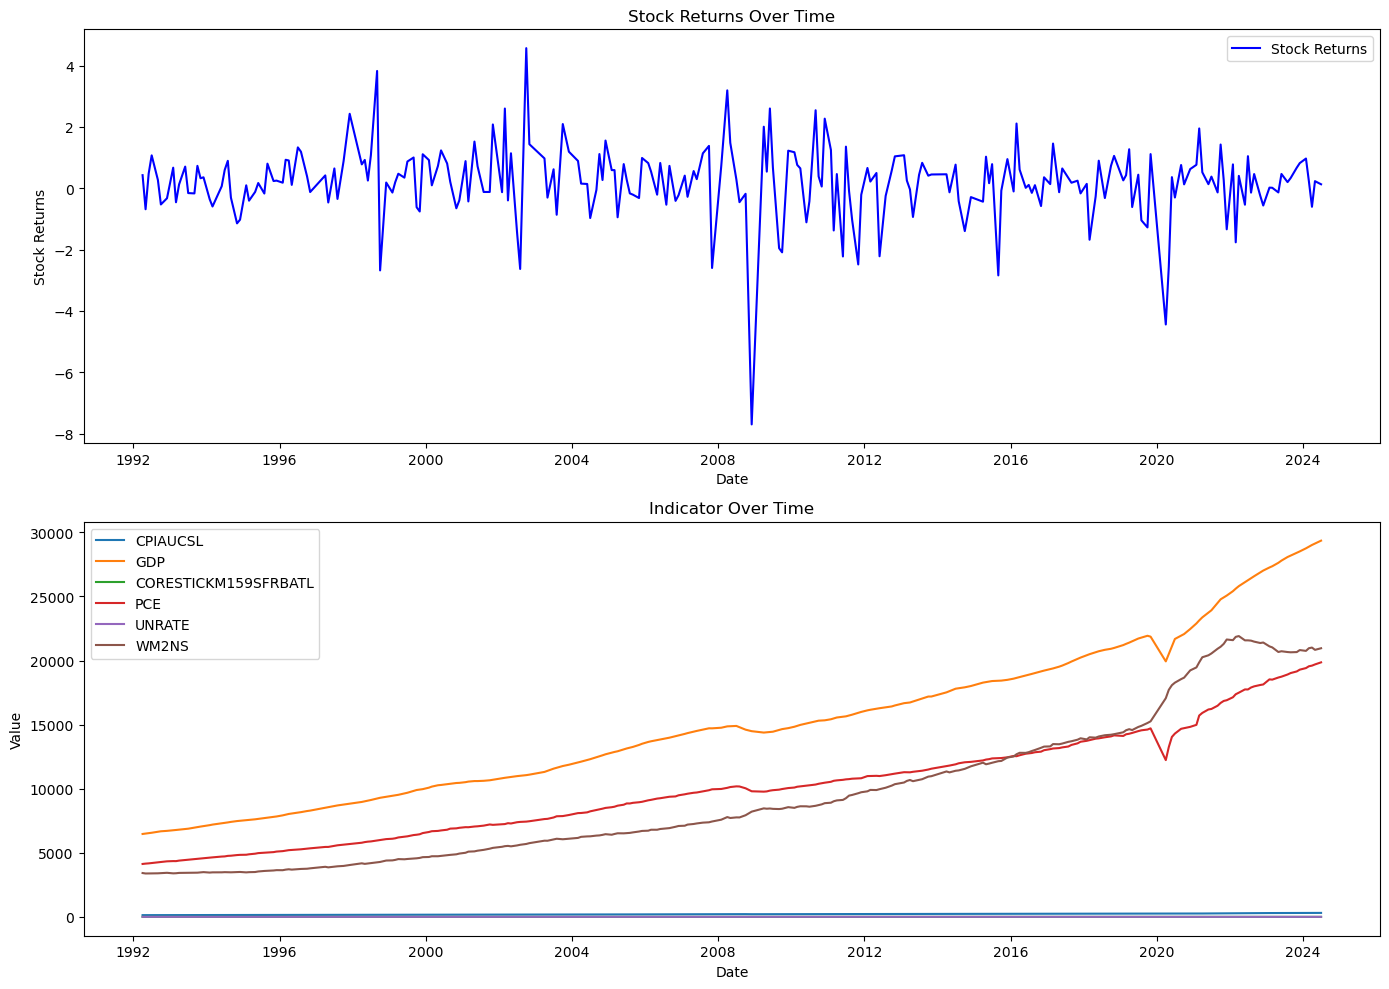

In [96]:
econ_indicators = ['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']
plt.figure(figsize=(14, 10))

# Plot stock returns
plt.subplot(2, 1, 1)
plt.plot(df5['Date'], df5['Returns'], label='Stock Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
plt.legend()

# Plot each economic indicator
for indicator in econ_indicators:
    plt.subplot(2, 1, 2)
    plt.plot(df5['Date'], df5[indicator], label=indicator)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Indicator Over Time')
    plt.legend()

plt.tight_layout()
plt.show()

#### Plotting actual vs predicted values

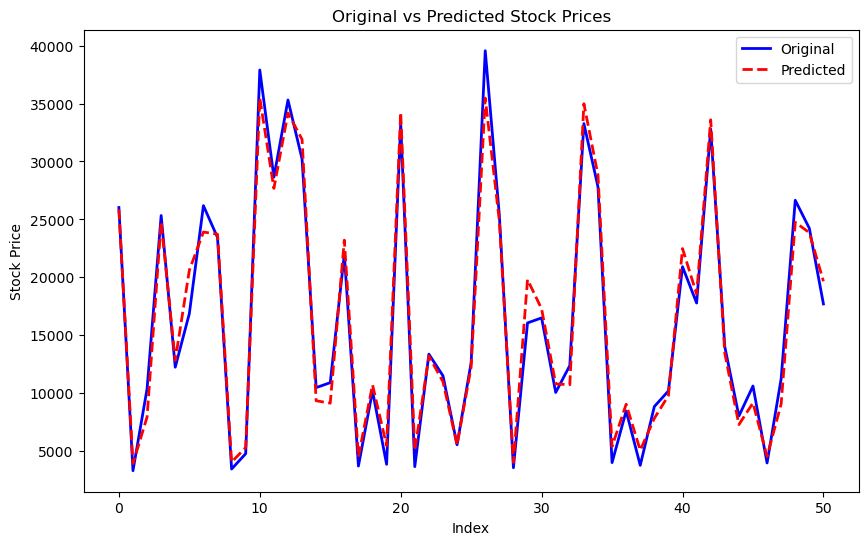

In [98]:
# Plot the original vs predicted values
plt.figure(figsize=(10, 6))

# Plotting the actual stock prices
plt.plot(y_test.values, label='Original', color='blue', linewidth=2)

# Plotting the predicted stock prices
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('Original vs Predicted Stock Prices')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()

# Display the plot
plt.show()

### Russell 3000 Index

#### Downloading Russell 3000 data from Yahoo finance

In [101]:
RUA = yf.download('^RUA', start=cpi['DATE'].min(), end=cpi['DATE'].max())
RUA

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-09-10,178.960007,178.960007,177.050003,178.830002,178.830002,0
1987-09-11,178.830002,181.470001,178.830002,181.339996,181.339996,0
1987-09-14,181.339996,182.250000,180.750000,181.789993,181.789993,0
1987-09-15,181.789993,181.789993,179.259995,179.270004,179.270004,0
1987-09-16,179.270004,180.630005,177.860001,177.889999,177.889999,0
...,...,...,...,...,...,...
2024-09-24,3265.810059,3267.399902,3248.689941,3266.709961,3266.709961,0
2024-09-25,3268.270020,3271.030029,3252.699951,3257.290039,3257.290039,0
2024-09-26,3282.389893,3282.800049,3258.790039,3271.179932,3271.179932,0


In [102]:
RUA.drop(['Open','High','Low','Close','Volume'],axis=1,inplace=True)

In [103]:
RUA

,Adj Close
Date,
1987-09-10,178.830002
1987-09-11,181.339996
1987-09-14,181.789993
1987-09-15,179.270004
1987-09-16,177.889999
...,...
2024-09-24,3266.709961
2024-09-25,3257.290039
2024-09-26,3271.179932


#### Calculating returns from the data

In [105]:
# Use adjusted close prices to calculate returns
RUA['Returns'] = RUA['Adj Close'].pct_change() * 100

In [106]:
RUA

,Adj Close,Returns
Date,,
1987-09-10,178.830002,NaN
1987-09-11,181.339996,1.403565
1987-09-14,181.789993,0.248151
1987-09-15,179.270004,-1.386209
1987-09-16,177.889999,-0.769791
...,...,...
2024-09-24,3266.709961,0.239653
2024-09-25,3257.290039,-0.288361
2024-09-26,3271.179932,0.426425


#### Merging the data

In [108]:
RUA = RUA.reset_index()
RUA['Date'] = pd.to_datetime(RUA['Date']).dt.date
data['DATE'] = pd.to_datetime(data['DATE']).dt.date

# Merge the datasets on the date
merged_data3 = pd.merge(RUA, data, left_on='Date', right_on='DATE', how='inner')

In [109]:
merged_data3

,Date,Adj Close,Returns,DATE,CPIAUCSL,GDP,CORESTICKM159SFRBATL,PCE,UNRATE,WM2NS
0,1987-10-01,184.139999,1.521664,1987-10-01,115.000,5007.994000,4.356982,3134.5,6.0,2810.6750000000000000
1,1987-12-01,130.009995,0.549104,1987-12-01,115.600,5051.579333,4.291749,3174.1,5.7,2837.1000000000000000
2,1988-02-01,143.949997,-0.408189,1988-02-01,116.200,5112.260000,4.375628,3221.4,5.7,2855.7200000000000000
3,1988-03-01,151.229996,-0.132072,1988-03-01,116.500,5151.148000,4.440937,3260.5,5.7,2885.3250000000000000
4,1988-06-01,151.550003,1.650015,1988-06-01,118.000,5251.902000,4.673118,3318.5,5.4,2935.1250000000000000
...,...,...,...,...,...,...,...,...,...,...
281,2024-03-01,2944.860107,0.776829,2024-03-01,312.230,28885.832333,4.509212,19553.2,3.8,20961.200000000000
282,2024-04-01,3004.219971,-0.288092,2024-04-01,313.207,29016.714000,4.412395,19603.3,3.9,21012.880000000000
283,2024-05-01,2871.199951,-0.240440,2024-05-01,313.225,29129.249667,4.302023,19697.3,4.0,20834.475000000000
284,2024-07-01,3104.090088,0.159081,2024-07-01,313.534,29354.321000,4.164951,19859.3,4.3,20960.100000000000


In [110]:
# Dropping the redundant 'DATE' column
merged_data3 = merged_data3.drop(columns=['DATE'])

df7 = merged_data3.dropna()

In [111]:
df7

,Date,Adj Close,Returns,CPIAUCSL,GDP,CORESTICKM159SFRBATL,PCE,UNRATE,WM2NS
0,1987-10-01,184.139999,1.521664,115.000,5007.994000,4.356982,3134.5,6.0,2810.6750000000000000
1,1987-12-01,130.009995,0.549104,115.600,5051.579333,4.291749,3174.1,5.7,2837.1000000000000000
2,1988-02-01,143.949997,-0.408189,116.200,5112.260000,4.375628,3221.4,5.7,2855.7200000000000000
3,1988-03-01,151.229996,-0.132072,116.500,5151.148000,4.440937,3260.5,5.7,2885.3250000000000000
4,1988-06-01,151.550003,1.650015,118.000,5251.902000,4.673118,3318.5,5.4,2935.1250000000000000
...,...,...,...,...,...,...,...,...,...
280,2024-02-01,2811.010010,1.248398,311.054,28754.950667,4.403102,19412.7,3.9,20754.950000000000
281,2024-03-01,2944.860107,0.776829,312.230,28885.832333,4.509212,19553.2,3.8,20961.200000000000
282,2024-04-01,3004.219971,-0.288092,313.207,29016.714000,4.412395,19603.3,3.9,21012.880000000000
283,2024-05-01,2871.199951,-0.240440,313.225,29129.249667,4.302023,19697.3,4.0,20834.475000000000


#### Creating a correlation matrix

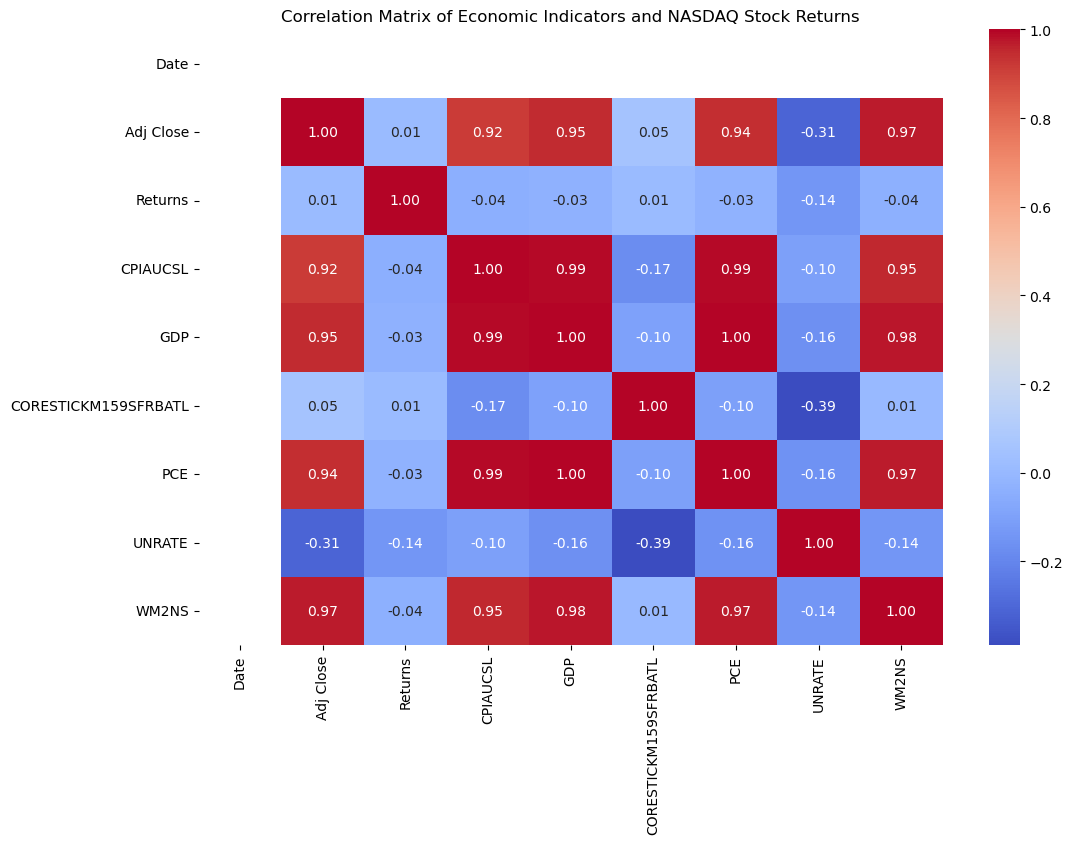

In [113]:
# Convert the dataframe to numeric, forcing errors to NaN
df8 = df7.apply(pd.to_numeric, errors='coerce')

# Now calculate the correlation matrix
corr_matrix = df8.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Economic Indicators and NASDAQ Stock Returns')
plt.show()

#### Splitting the data into train and test model

In [115]:
X = df7[['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']]  # Economic indicators
y = df7['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Developing Linear Regression model

In [117]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 12762.168991233935


#### Identifying coefficients of the model

In [119]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients

,Coefficient
CPIAUCSL,-5.953675
GDP,0.203372
CORESTICKM159SFRBATL,-20.859649
PCE,-0.203369
UNRATE,-65.804644
WM2NS,0.099688


In [120]:
print(f"R-squared: {model.score(X, y)}")

R-squared: 0.9703768988528088


In [121]:
df7['WM2NS']=pd.to_numeric(df7['WM2NS'])

C:\Users\Varad\AppData\Local\Temp\ipykernel_20616\2326213021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['WM2NS']=pd.to_numeric(df7['WM2NS'])


In [122]:
x=df7[["CPIAUCSL","GDP","CORESTICKM159SFRBATL","PCE","UNRATE","WM2NS"]]
sm.OLS(df7['Adj Close'], sm.add_constant(x)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1533.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          8.96e-210
Time:                        21:21:28   Log-Likelihood:                -1773.6
No. Observations:                 285   AIC:                             3561.
Df Residuals:                     278   BIC:                             3587.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  786.1723    199.406      3.943      0.000     393.635    1178.710
CPIAUCSL                -6.2911      2.439     -2.580      0.010     -11.092      -1.490
GDP                      0.2211      0.051      4.344      0.000       0.121       0.321
CORESTICKM159SFRBATL   -26.7633      8.432     -3.174      0.002     -43.361     -10.165
PCE                     -0.2259      0.066     -3.411      0.001      -0.356      -0.096
UNRATE                 -64.1188      6.367    -10.070      0.000     -76.653     -51.585
WM2NS                    0.0986      0.010     10.003      0.000       0.079       0.118
==============================================================================
Omnibus:                       53.887   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.859
Skew:                           0.861   Prob(JB):                     9.52e-32
Kurtosis:                       6.010   Cond. No.                     5.79e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Plotting actual vs predicted values

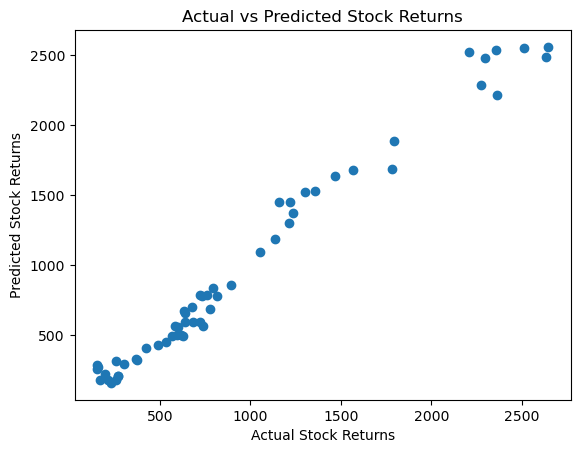

In [124]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Stock Returns')
plt.ylabel('Predicted Stock Returns')
plt.title('Actual vs Predicted Stock Returns')
plt.show()

#### Plotting the data

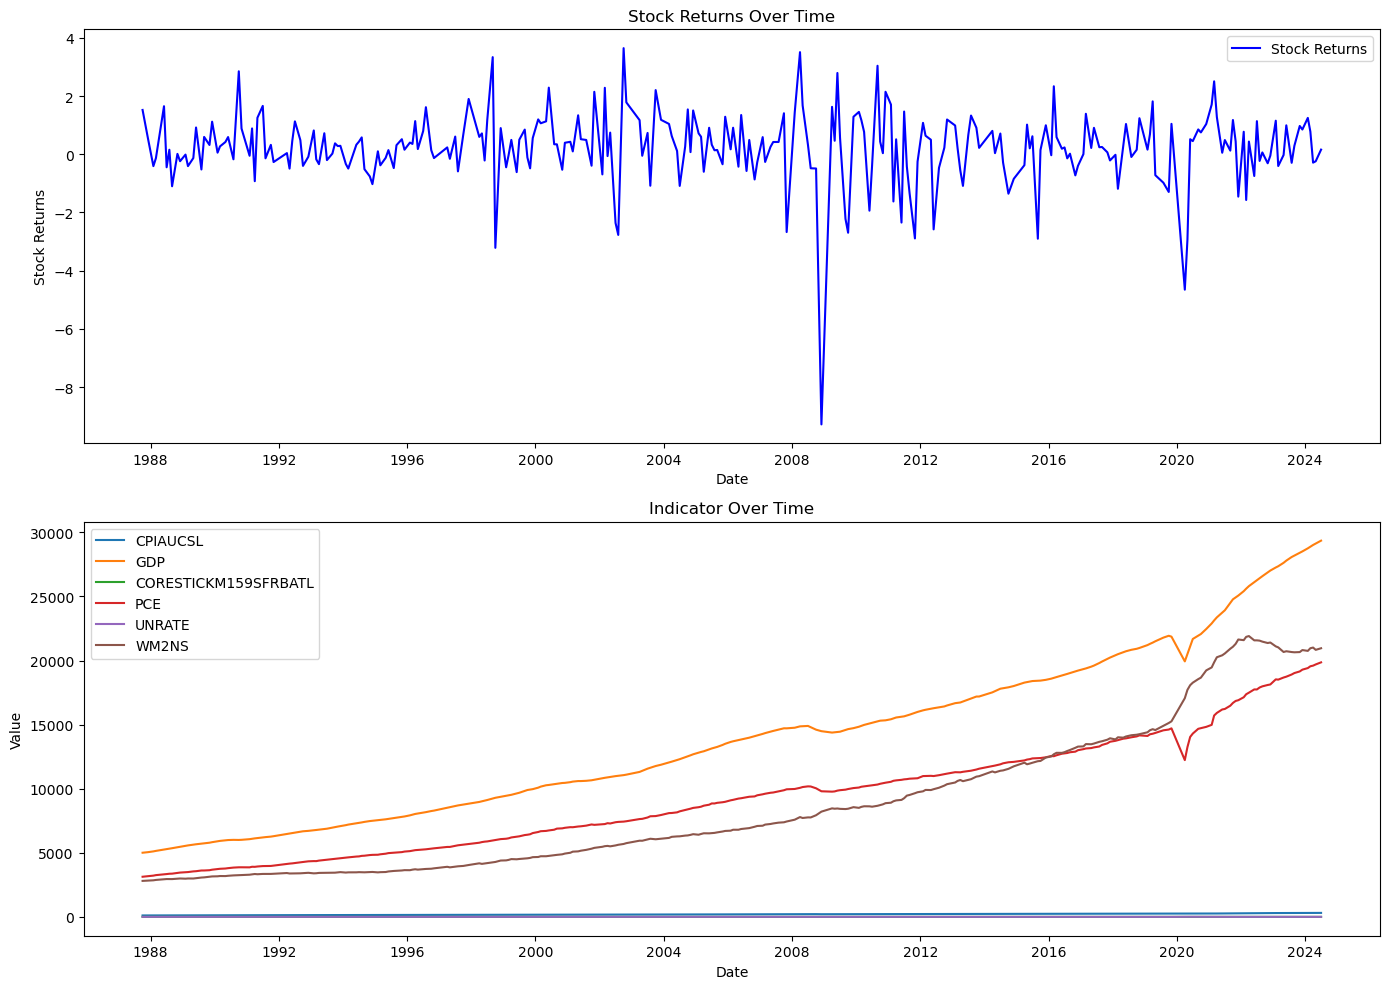

In [126]:
econ_indicators = ['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']
plt.figure(figsize=(14, 10))

# Plot stock returns
plt.subplot(2, 1, 1)
plt.plot(df7['Date'], df7['Returns'], label='Stock Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
plt.legend()

# Plot each economic indicator
for indicator in econ_indicators:
    plt.subplot(2, 1, 2)
    plt.plot(df7['Date'], df7[indicator], label=indicator)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Indicator Over Time')
    plt.legend()

plt.tight_layout()
plt.show()

#### Plotting actual vs predicted values

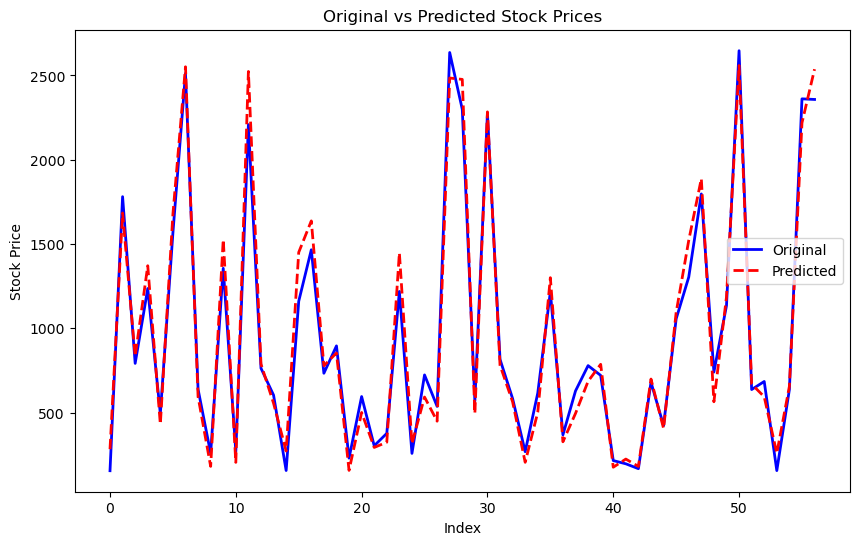

In [128]:
# Plot the original vs predicted values
plt.figure(figsize=(10, 6))

# Plotting the actual stock prices
plt.plot(y_test.values, label='Original', color='blue', linewidth=2)

# Plotting the predicted stock prices
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('Original vs Predicted Stock Prices')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()

# Display the plot
plt.show()

In [129]:
indices = ['^GSPC', '^DJI', '^IXIC', '^RUA']  # S&P 500, DJ, NASDAQ, Russell 2000
mse_values = {}
r2_values = {}

for index in indices:
    # Download data, prepare features (economic indicators), and split data for the current index
    stock_data = yf.download(index, start=cpi['DATE'].min(), end=cpi['DATE'].max())
    stock_data['Returns'] = stock_data['Adj Close'].pct_change() * 100
    stock_data = stock_data.reset_index()
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
    merged_data = pd.merge(stock_data, data, left_on='Date', right_on='DATE', how='inner')
    merged_data = merged_data.dropna()
    
    X = merged_data[['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']]
    y = merged_data['Adj Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute MSE and R-squared
    mse_values[index] = mean_squared_error(y_test, y_pred)
    r2_values[index] = r2_score(y_test, y_pred)



results_df = pd.DataFrame({
    'Index': indices,
    'MSE': [mse_values[index] for index in indices],
    'R-squared': [r2_values[index] for index in indices]
})

# Display the DataFrame
print(results_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

   Index           MSE  R-squared
0  ^GSPC  4.390977e+04   0.976395
1   ^DJI  2.236757e+06   0.979453
2  ^IXIC  8.707351e+05   0.955521
3   ^RUA  1.276217e+04   0.975093


In [130]:
# Normalize MSE and R-squared for comparison
results_df['Normalized_MSE'] = (results_df['MSE'] - results_df['MSE'].min()) / (results_df['MSE'].max() - results_df['MSE'].min())
results_df['Normalized_R_squared'] = (results_df['R-squared'] - results_df['R-squared'].min()) / (results_df['R-squared'].max() - results_df['R-squared'].min())

# Calculate a combined score (higher is better)
# We subtract Normalized_MSE because lower MSE is better
results_df['Score'] = results_df['Normalized_R_squared'] - results_df['Normalized_MSE']

# Find the index with the best score
best_index = results_df.loc[results_df['Score'].idxmax()]

print("Results DataFrame:")
print(results_df)
print("\nIndex with the best combination of lowest MSE and highest R-squared:")
print(best_index)


Results DataFrame:
   Index           MSE  R-squared  Normalized_MSE  Normalized_R_squared  \
0  ^GSPC  4.390977e+04   0.976395        0.014005              0.872259   
1   ^DJI  2.236757e+06   0.979453        1.000000              1.000000   
2  ^IXIC  8.707351e+05   0.955521        0.385780              0.000000   
3   ^RUA  1.276217e+04   0.975093        0.000000              0.817820   

      Score  
0  0.858254  
1  0.000000  
2 -0.385780  
3  0.817820  

Index with the best combination of lowest MSE and highest R-squared:
Index                          ^GSPC
MSE                     43909.765839
R-squared                   0.976395
Normalized_MSE              0.014005
Normalized_R_squared        0.872259
Score                       0.858254
Name: 0, dtype: object


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


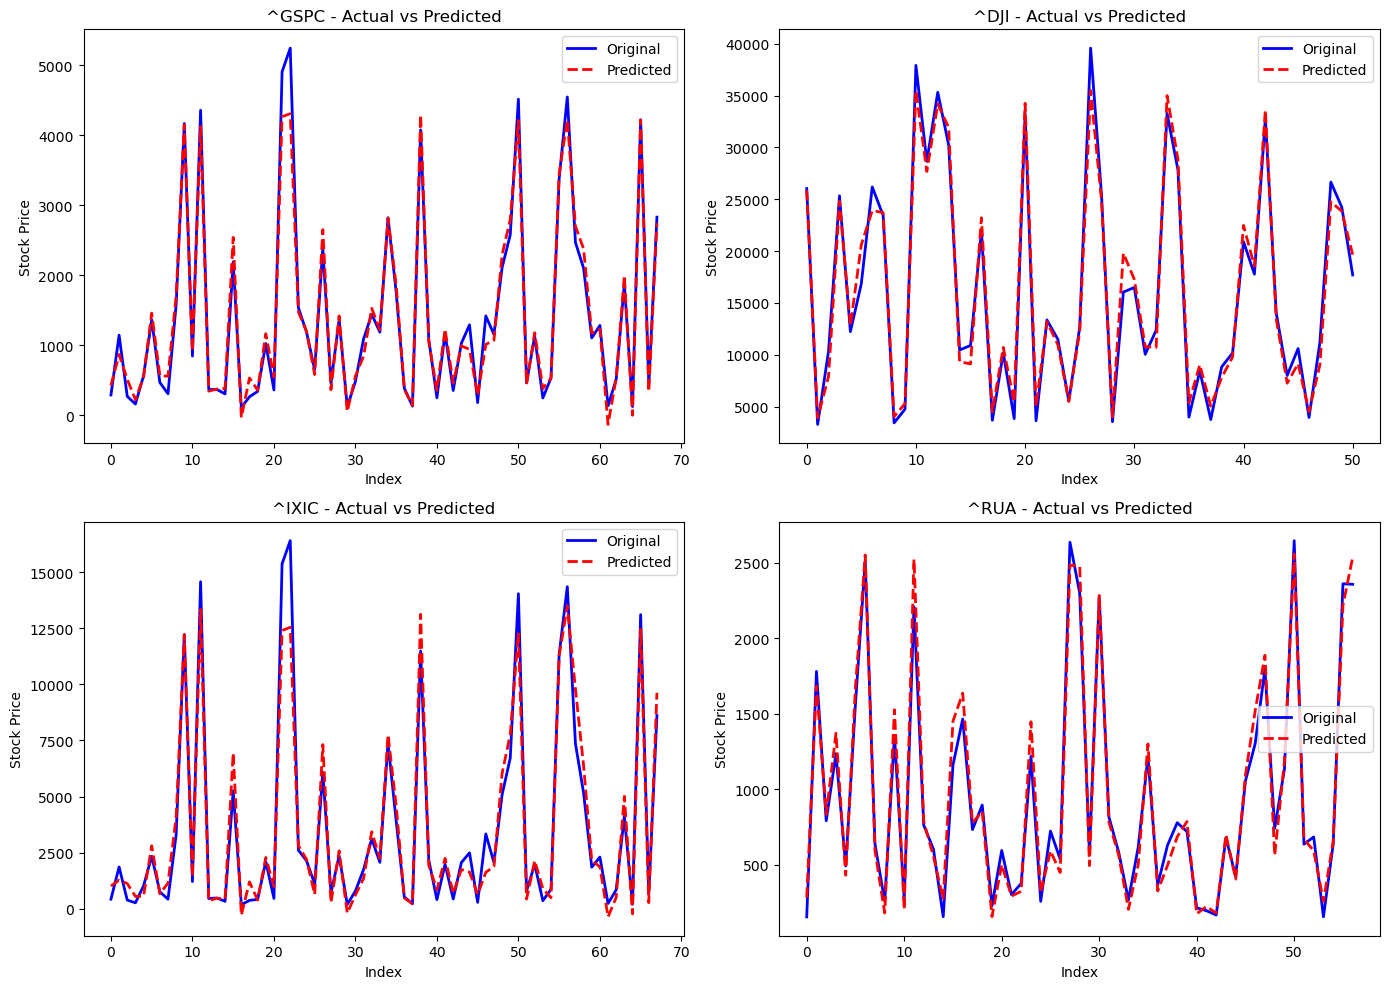

In [131]:
plt.figure(figsize=(14, 10))

for i, index in enumerate(indices):
    plt.subplot(2, 2, i+1)
    stock_data = yf.download(index, start=cpi['DATE'].min(), end=cpi['DATE'].max())
    stock_data['Returns'] = stock_data['Adj Close'].pct_change() * 100
    stock_data = stock_data.reset_index()
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
    merged_data = pd.merge(stock_data, data, left_on='Date', right_on='DATE', how='inner')
    merged_data = merged_data.dropna()
    
    X = merged_data[['CPIAUCSL', 'GDP', 'CORESTICKM159SFRBATL', 'PCE', 'UNRATE', 'WM2NS']]
    y = merged_data['Adj Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Plot Actual vs Predicted
    plt.plot(y_test.values, label='Original', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)
    plt.title(f'{index} - Actual vs Predicted')
    plt.xlabel('Index')
    plt.ylabel('Stock Price')
    plt.legend()

plt.tight_layout()
plt.show()


## Analysis - 

### Based on the fitting of data, every market has different relationship with different economic indicators, and the final conclusion is that depending on the risk appetite, a risky investor might try to invest into NASDAQ given its sector concetration and the effect of economic indicators, however, a risk averse one would like to take the other ones which are pretty diversified and don't have extreme effects to economic changes